## Remote Pigments

In [5]:
import sys
sys.version
import spectral as spec_pack
import spectral.io.envi as envi
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import skimage
%matplotlib inline
import gdal
import pylab

In [6]:
def aop_h5refl2array(refl_filename):
    """read in NEON AOP reflectance hdf5 file, convert to a cleaned reflectance 
    array and return associated metadata (spatial information and band center 
    wavelengths)
           
    Parameters
    ----------
        refl_filename : string
            reflectance hdf5 file name, including full or relative path

    Returns 
    --------
    reflArray : ndarray
        array of reflectance values
    metadata: dictionary 
        associated metadata containing
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: center wavelengths of bands (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """
    
    import h5py
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')
    
    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']
    
    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 
    
    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']
    
    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, metadata

In [7]:
def stack_rgb(reflArray,bands): 
    ''' extract and stack three bands of a reflectance array 
    --------
    Parameters
    --------
        reflArray: ndarray (m x n x #bands)
            Array of reflectance values, created from aop_h5refl2array
        bands: tuple
            Indices of bands to extract (R,G,B)

    Returns 
    --------
        stackedRGB: ndarray (m x n x 3)
            array containing 3 bands specified 
    --------

    Examples:
    --------
    >>> stack_rgbstack_rgb(sercRefl,(58,34,19)) '''
    
    import numpy as np
    
    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]
    
    stackedRGB = np.stack((red,green,blue),axis=2)
    
    return stackedRGB

In [8]:
# %load ../neon_functions/plot_aop_rgb.py
def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):
    
    ''' read in and plots 3 bands of a reflectance array as an RGB image
    --------
    Parameters
    --------
        rgbArray: ndarray (m x n x 3)
            3-band array of reflectance values, created from stack_rgb
        ext: tuple
            Extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
            Stored in metadata['spatial extent'] from aop_h5refl2array function
        ls_pct: integer or float, optional
            linear stretch percent
        plot_title: string, optional
            image title

    Returns 
    --------
        plots RGB image of 3 bands of reflectance data
    --------

    Examples:
    --------
    >>> plot_aop_rgb(SERCrgb,
                     sercMetadata['spatial extent'],
                     plot_title = 'SERC RGB')'''
    
    from skimage import exposure
    
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [11]:
def see_tile(tile_name):
    refl_array, metadata = aop_h5refl2array(tile_name)
    stacked_images = stack_rgb(refl_array,(58,34,19))
    plot_aop_rgb(stacked_images,metadata['spatial extent'])

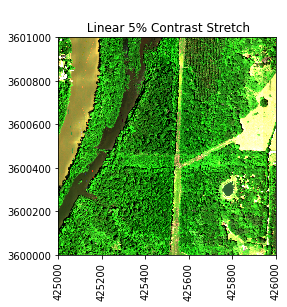

In [12]:
tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_425000_3600000_reflectance.h5' # narrow to the east of imagined buoy
see_tile(tile_filename)

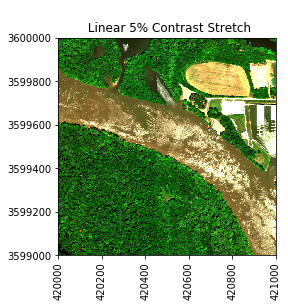

In [14]:
tile_filename='../data/dev_tile.h5' # just downstream of the confluence
see_tile(tile_filename)


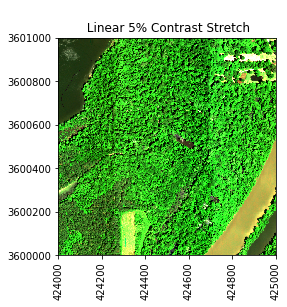

In [15]:
tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_424000_3600000_reflectance.h5' # just to the left of sensor
see_tile(tile_filename)



% No Data:  5.2


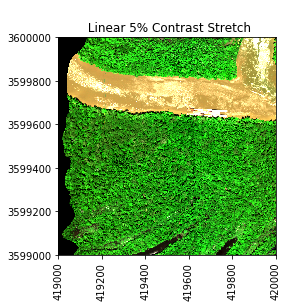

In [16]:
tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_419000_3599000_reflectance.h5' # confluence!
see_tile(tile_filename)


% No Data:  9.5


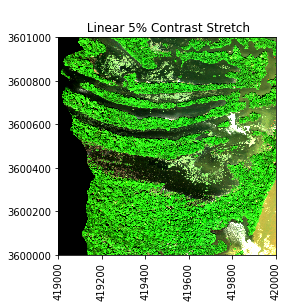

In [17]:

tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_419000_3600000_reflectance.h5' # right in between tombigbee and black warriror, above confluence
see_tile(tile_filename)



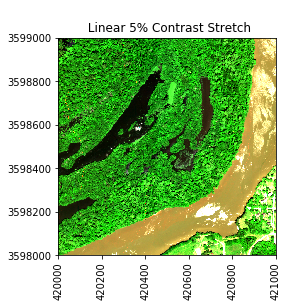

In [18]:
tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_420000_3598000_reflectance.h5'
see_tile(tile_filename)


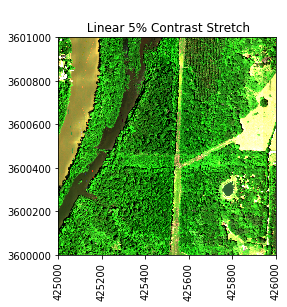

In [19]:
tile_filename='/Volumes/Erasmus/NEON_data/project_data/dela_tiles/NEON_D08_DELA_DP3_425000_3600000_reflectance.h5' # narrow to the east of imagined buoy
see_tile(tile_filename)
